In [1]:
import socratic

	Loading CLIP ViT-L/14
	Loading precomputed zeroshot classifier
	Building simple zeroshot classifier


Loading embeddings
number of images before deduplicate:  50
number of images after deduplicate:  27


100%|██████████| 27/27 [00:00<00:00, 209.90it/s]

{'objects': ['Sand tiger shark', 'Broadnose shark', 'Nurse shark', 'Requiem shark', 'Bull shark', 'whitetip shark, reef whitetip shark, Triaenodon obseus', 'sandbar shark, Carcharhinus plumbeus', 'requiem shark', 'sand tiger, sand shark, Carcharias taurus, Odontaspis taurus', 'blacktip shark, sandbar shark, Carcharhinus limbatus'], 'places': ['aquarium', 'ocean deep underwater', 'indoor museum', 'ocean', 'indoor swimming pool']}
{'objects': ['Walt disney world', 'Queue area', 'Parade', 'Theatrical scenery', 'Castle', 'castle', 'palace', 'palace', 'cloak', 'cloak'], 'places': ['outdoor stage', 'throne room', 'castle', 'palace', 'performance arena']}
{'objects': ['Jollyboat', 'Walt disney world', 'Theatrical scenery', 'Land sailing', 'Animated cartoon', 'gangplank, gangboard, gangway', 'jolly boat, jolly', 'pirate, pirate ship', 'Peter Pan', 'shooting gallery'], 'places': ['galley', 'amusement park', 'toyshop', 'carrousel', 'boat deck']}
{'objects': ['Mariachi', 'Jollyboat', 'Pandero jar

[['swimming', 'diving', 'snorkeling'], ['swimming', 'diving', 'snorkeling'], ['swimming', 'diving']]
[['Watching a parade', 'Watching a show'], ['Watching a parade', 'Watching a show'], ['Watching a parade', 'Watching a show']]
[['float', 'merry', 'round', 'roundabout', 'whirligig'], ['float', 'merry', 'round', 'roundabout', 'whirligig'], ['float', 'merry', 'round', 'roundabout', 'whirligig']]
[['queue', 'ice cream bar', 'frozen dessert'], ['queue', 'ice cream bar', 'frozen dessert'], ['queue', 'ice cream bar', 'frozen dessert']]


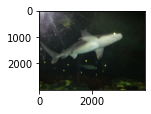

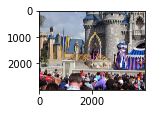

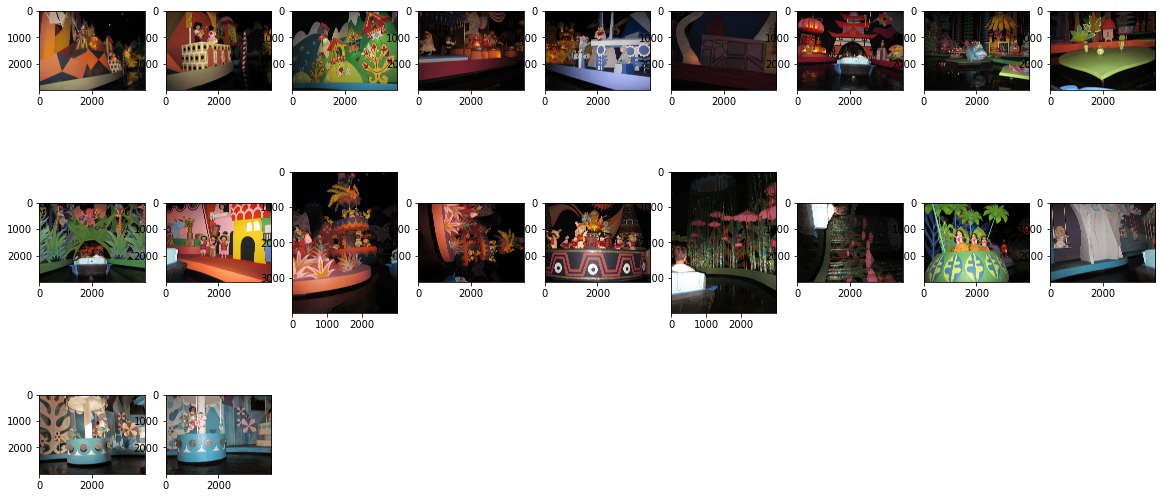

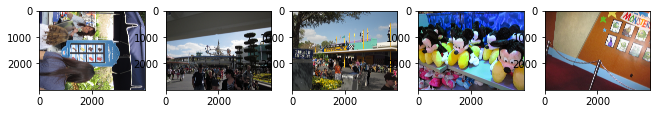

In [91]:
import os
import torch

import matplotlib.pyplot as plt
import numpy as np
import pickle
import datetime

from io import BytesIO
from PIL import Image
from tqdm import tqdm
from collections import Counter

# loading inputs (image, location, date/time)
def load_examples():
    """Load example images"""
    images = []
    path = './examples'
    fns = os.listdir(path)
    for fn in fns:
        fn = os.path.join(path, fn)
        if '.jpg' in fn.lower():
            img = Image.open(fn)
            images.append(img)
    
    # datetimes = []
    # for img in images:
    #     datetimes.append(img.getexif()[306])

    # sort images by time
    images.sort(key=lambda im: im.getexif()[306])

    return images

def encode_image(img):
    """Encode an image using CLIP"""
    image_input = socratic.model_dict['clip_preprocess'](img)\
        .unsqueeze(0).to(socratic.model_dict['device'])
    with torch.no_grad():
        image_features = socratic.model_dict['clip_model'].encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    
    return image_features


def visualize(images):
    """Show the first 36 images"""
    plt.figure(figsize=(20,10))
    columns = 9
    for i, image in enumerate(images[:36]):
        plt.subplot(len(images) // columns + 1, columns, i + 1)
        plt.imshow(image)


def object_detection(images, embeddings=None, k=5):
    """Perform zero-shot image classification"""
    model_dict = socratic.model_dict
    drop_gpu = socratic.drop_gpu
    result = []

    for i, image in tqdm(enumerate(images), total=len(images)):
        with torch.no_grad():
            if embeddings is None:
                image_input = model_dict['clip_preprocess'](image).unsqueeze(0).to(model_dict['device'])
                image_features = model_dict['clip_model'].encode_image(image_input)
                image_features /= image_features.norm(dim=-1, keepdim=True)
            else:
                image_features = embeddings[i]

            sim = (100.0 * image_features @ model_dict['openimage_classifier_weights'].T).softmax(dim=-1)
            openimage_scores, indices = [drop_gpu(tensor) for tensor in sim[0].topk(k)]
            openimage_classes = [model_dict['openimage_classnames'][idx] for idx in indices]

            sim = (100.0 * image_features @ model_dict['tencentml_classifier_weights'].T).softmax(dim=-1)
            tencentml_scores, indices = [drop_gpu(tensor) for tensor in sim[0].topk(k)]
            tencentml_classes = [model_dict['tencentml_classnames'][idx] for idx in indices]

            sim = (100.0 * image_features @ model_dict['place365_classifier_weights'].T).softmax(dim=-1)
            place365_scores, indices = [drop_gpu(tensor) for tensor in sim[0].topk(k)]
            place365_classes = [model_dict['place365_classnames'][idx] for idx in indices]

            objects = {'objects': openimage_classes + tencentml_classes,
                       'places': place365_classes}
            result.append(objects)

    return result

def create_segments(images, embeddings, objects):
    """Create segments of the timeline"""
    # TODO: this part needs to be replaced by the values from LLEntries
    def get_ts(obj):
        img = obj[0]
        return datetime.datetime.strptime(img.getexif()[306], '%Y:%m:%d %H:%M:%S').timestamp()

    lst = [images]
    if embeddings is not None:
        lst.append(embeddings)
    if objects is not None:
        lst.append(objects)

    items = list(zip(*lst))
    eps = 1800
    clusters = []
    
    curr_point = items[0]
    curr_cluster = [curr_point]
    for point in items[1:]:
        if get_ts(point) <= get_ts(curr_point) + eps:
            curr_cluster.append(point)
        else:
            clusters.append(curr_cluster)
            curr_cluster = [point]
        curr_point = point
    clusters.append(curr_cluster)
    return clusters

def activity_detection(segment):
    """Classify activity of a segment by sending a query to Bloom"""
    objects_cnt = Counter()
    places_cnt = Counter()

    for item in segment:
        for o in item[2]['objects']:
            objects_cnt[o] += 1
        for p in item[2]['places']:
            places_cnt[p] += 1
    
    sorted_places = list(zip(*places_cnt.most_common(3)))[0]
    object_list = ', '.join(list(zip(*objects_cnt.most_common(10)))[0])

    prompt = f'''I am an intelligent image captioning bot. 
       I am going to describe the activities in photos.
       I think these photos were taken at a {sorted_places[0]}, {sorted_places[1]}, or {sorted_places[2]}.
       I think there might be a {object_list} in thses photos.
       I think the activities in these photos are:'''

    response = socratic.generate_captions(prompt)
    def postprocess(answer):
        answer = answer.replace('\n', ',').replace('-', ',').replace('.', ',')
        items = [item.strip() for item in answer.split(',')]
        items = list(Counter([item for item in items if len(item) >= 5]).keys())
        return items
    
    return [postprocess(r) for r in response]


def process(images, locations=None, datetimes=None):
    # obtain image embeddings
    embeddings = []
    if os.path.exists("embeddings.pkl"):
        print("Loading embeddings")
        embeddings = pickle.load(open("embeddings.pkl", "rb"))
    else:
        print("Computing embeddings")
        for img in tqdm(images):
            embeddings.append(encode_image(img))
        pickle.dump(embeddings, open("embeddings.pkl", "wb"))

    # image deduplication: find images with cosine similarity over a threshold
    # visualize(images)
    dedup_images = []
    dedup_embeddings = []
    for i in range(len(images)):
        emb_i = embeddings[i]
        duplicate = False
        for j in range(i):
            emb_j = embeddings[j]
            sim = torch.dot(emb_i.squeeze(0), emb_j.squeeze(0)).numpy()
            if sim > 0.9:
                duplicate = True
                break
        if not duplicate:
            dedup_images.append(images[i])
            dedup_embeddings.append(embeddings[i])
    
    print("number of images before deduplicate: ", len(images))
    print("number of images after deduplicate: ", len(dedup_images))
    # visualize(dedup_images)

    # object detection
    objects = object_detection(dedup_images, dedup_embeddings)
    for line in objects:
        print(line)

    # segment images
    # visualize(dedup_images)
    segments = create_segments(dedup_images, dedup_embeddings, objects)
    for seg in segments:
        imgs = [s[0] for s in seg]
        visualize(imgs)

    # run activity detection
    for seg in segments:
        activity = activity_detection(seg)
        print(activity)
    

images = load_examples()[:50]
process(images)
# print(len(images))